In [ ]:
import os, glob, re, cv2
import numpy as np
import albumentations as A
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pickle
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, UpSampling2D, Concatenate, GlobalAveragePooling2D, Reshape, multiply, AveragePooling2D
%matplotlib inline

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def preprocess_image(img, shape=256, use_gaussian_blur=False):
    # Resize
    img = cv2.resize(img, (shape, shape))
    # Normalize to [0,1]
    img = img.astype(np.float32) / 255.0
    # Gaussian Blur
    if use_gaussian_blur:
        img = cv2.GaussianBlur(img, (3,3),0)
    return img

In [3]:
def preprocess_mask(mask, shape=256):
    # Resize and keep as integer labels
    mask = cv2.resize(mask, (shape, shape), interpolation=cv2.INTER_NEAREST)
    mask[mask == 128] = 1
    mask[mask == 255] = 2
    return mask

In [6]:
framObjTrain = {'img' : [],
           'mask' : []
          }

In [7]:
def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=256):
    if frameObj is None:
        frameObj = {'img': [], 'mask': []}
        
    imgNames = os.listdir(imgPath)
    unames = [imgNames[i].split(')')[0] for i in range(len(imgNames)) if '.png' in imgNames[i]]
    unames = list(set(unames))

    for uname in unames:
        img_name = f'{uname}).png'
        mask_name = f'{uname})_mask.png'

        img_path = os.path.join(imgPath, img_name)
        mask_path = os.path.join(maskPath, mask_name)

        if not os.path.exists(mask_path):
            print(f"Mask tidak ditemukan: {mask_path}")
            continue

        # Baca gambar
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (shape, shape))

        # Baca dan ubah mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (shape, shape), interpolation=cv2.INTER_NEAREST)

        mask[mask == 128] = 0  
        mask[mask == 255] = 1  
        mask[(mask != 0) & (mask != 1)] = 0  

        frameObj['img'].append(img.astype(np.float32)/255.0)
        frameObj['mask'].append(mask.astype(np.uint8))

    return frameObj

In [8]:
# Load data
framObjTrain = LoadData(framObjTrain, imgPath='D:/semester 6/skrpsi/breast cancer/USG/Dataset_BUSI_with_GT/benign',
                        maskPath='D:/semester 6/skrpsi/breast cancer/USG/Dataset_BUSI_with_GT/benign',
                        shape=256)

framObjTrain = LoadData(framObjTrain, imgPath='D:/semester 6/skrpsi/breast cancer/USG/Dataset_BUSI_with_GT/malignant',
                        maskPath='D:/semester 6/skrpsi/breast cancer/USG/Dataset_BUSI_with_GT/malignant',
                        shape=256)

In [9]:
for i in range(len(framObjTrain['img'])):
    img = framObjTrain['img'][i]
    mask = framObjTrain['mask'][i]
    assert img.shape == (256, 256, 3), f"Shape gambar ke-{i} salah: {img.shape}"
    assert mask.shape == (256, 256), f"Shape mask ke-{i} salah: {mask.shape}"

In [10]:
np.count_nonzero(mask)

5505

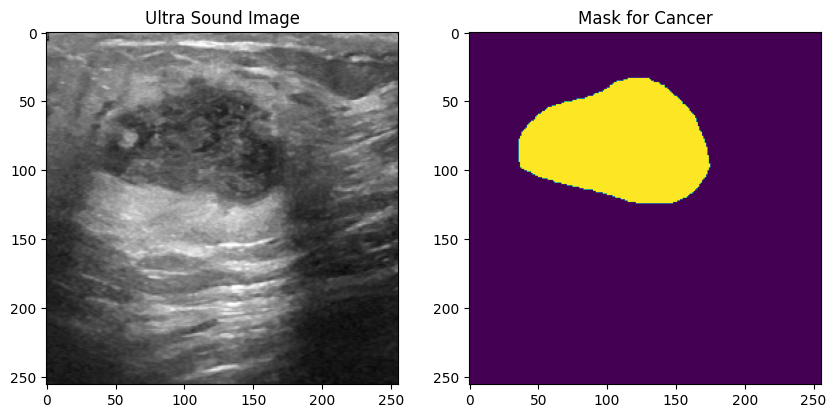

In [11]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.title('Mask for Cancer')
plt.show()

In [12]:
flat_mask = np.concatenate([m.flatten() for m in framObjTrain['mask']])
unique, counts = np.unique(flat_mask, return_counts=True)
print("Distribusi kelas:", dict(zip(unique, counts)))

Distribusi kelas: {np.uint8(0): np.int64(38457171), np.uint8(1): np.int64(3944621)}


In [13]:
# Convert ke numpy
X = np.array(framObjTrain['img'])
y = np.array(framObjTrain['mask'])

In [14]:
# Split data menjadi train dan validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape) 

(517, 256, 256, 3) (130, 256, 256, 3) (517, 256, 256) (130, 256, 256)


In [15]:
# One-hot encode y_train dan y_val
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)

In [16]:
print("Setelah one-hot encoding:")
print("y_train_cat.shape =", y_train_cat.shape)
print("y_val_cat.shape =", y_val_cat.shape)

Setelah one-hot encoding:
y_train_cat.shape = (517, 256, 256, 2)
y_val_cat.shape = (130, 256, 256, 2)


In [17]:
empty_masks = 0
for i, mask in enumerate(y_train):
    if np.sum(mask) == 0:
        print(f"Mask kosong di indeks {i}")
        empty_masks += 1
print(f"Total mask kosong di y_train: {empty_masks}")

Total mask kosong di y_train: 0


In [18]:
print(np.unique(y_train, return_counts=True))

(array([0, 1], dtype=uint8), array([30731489,  3150623]))


In [19]:
# Save split data
with open('data_split.pkl', 'wb') as f:
    pickle.dump((X_train, X_val, y_train_cat, y_val_cat), f)

In [20]:
%reload_ext autoreload
%autoreload 2